# Лабораторная работа №5: Линейная регрессия на Movies Dataset

**Датасет:** Kaggle The Movies Dataset (https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data)

**Цель:** предсказать доход (`revenue`) фильма на основе его признаков.

## 1. Загрузка данных

In [10]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

# Загрузите `movies_metadata.csv` в рабочую директорию перед запуском
df = pd.read_csv('movies_metadata.csv', low_memory=False)
print(f"Всего записей: {df.shape[0]}, столбцов: {df.shape[1]}")
df.head()

Всего записей: 45466, столбцов: 24


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## 2. Предобработка данных (Этап 1)

После очистки осталось 45203 записей из 45466


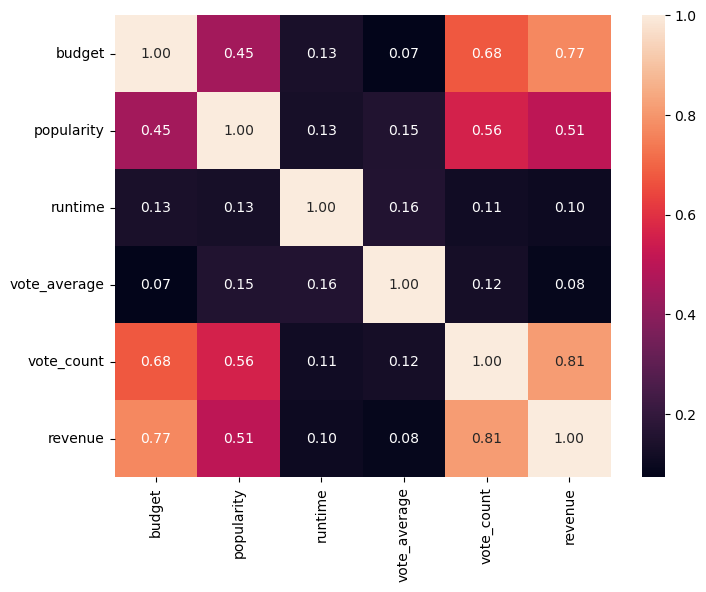

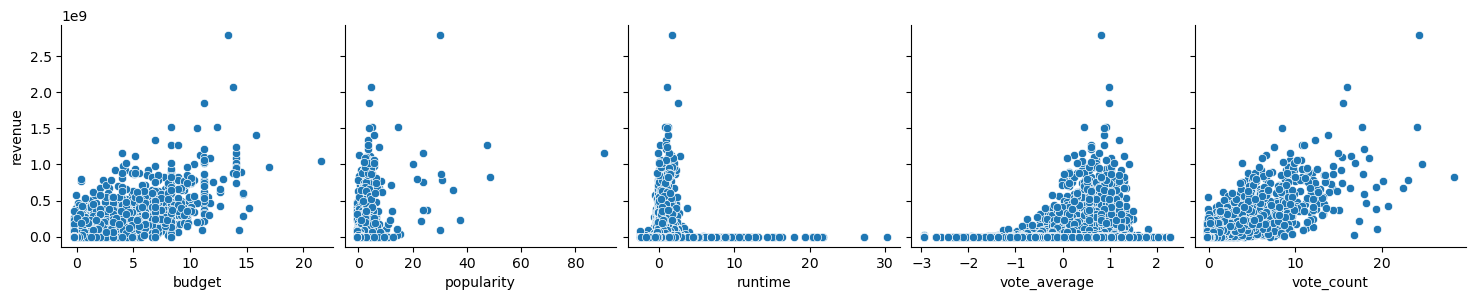

In [11]:
# Выбираем числовые признаки и целевую
numeric_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
target = 'revenue'

df1 = df[numeric_features + [target]].dropna()
print(f"После очистки осталось {df1.shape[0]} записей из {df.shape[0]}")

# Нормализация
scaler = StandardScaler()
X1 = scaler.fit_transform(df1[numeric_features])
y1 = df1[target].values

# Корреляции и визуализации
corr = pd.DataFrame(X1, columns=numeric_features).join(pd.Series(y1, name=target)).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()
sns.pairplot(pd.DataFrame(X1, columns=numeric_features).assign(revenue=y1), x_vars=numeric_features, y_vars=target, height=3, aspect=1)
plt.show()

# Разбиение данных
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [12]:
# %% 
# 2.1 Лог-трансформация целевой переменной
# (чтобы сгладить разброс revenue и получить более адекватную метрику)
y1_log = np.log1p(y1)  # log(1 + revenue)

# Разбиение данных на train/test
X1_train, X1_test, y1_train_log, y1_test_log = train_test_split(
    X1, y1_log, test_size=0.2, random_state=42
)


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

params = {'alpha': np.logspace(-3, 3, 10)}
ridge = Ridge()

gs = GridSearchCV(ridge, params, cv=5, scoring='neg_mean_squared_error')
gs.fit(X1_train, y1_train_log)

print("Лучшие α:", gs.best_params_)
y_pred_log = gs.predict(X1_test)

# Обратно к исходной шкале:
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y1_test_log)

from sklearn.metrics import mean_squared_error
print("RMSE после лог-трансформации:", np.sqrt(mean_squared_error(y_true, y_pred)))


Лучшие α: {'alpha': 215.44346900318823}
RMSE после лог-трансформации: 3.402822348309832e+90


## 3. Линейная регрессия МНК

In [18]:
lr = LinearRegression()
lr.fit(X1_train, y1_train)
y1_pred = lr.predict(X1_test)

mse1 = mean_squared_error(y1_test, y1_pred)
mae1 = mean_absolute_error(y1_test, y1_pred)
r2_1 = r2_score(y1_test, y1_pred)
print(f"LinearRegression без категорий: MSE={mse1:.2f}, MAE={mae1:.2f}, R2={r2_1:.2f}")

LinearRegression без категорий: MSE=1337433744976479.50, MAE=9812426.60, R2=0.73


## 4. Регуляризованные регрессии (Ridge, Lasso, ElasticNet)

In [15]:
models = {
    'Ridge': (Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]}),
    'Lasso': (Lasso(max_iter=10000), {'alpha': [0.01, 0.1, 1, 10, 100]}),
    'ElasticNet': (ElasticNet(max_iter=10000), {'alpha': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.9]})
}
best_models = {}
for name, (est, params) in models.items():
    gs = GridSearchCV(est, params, cv=5)
    gs.fit(X1_train, y1_train)
    best = gs.best_estimator_
    y_pred = best.predict(X1_test)
    mse = mean_squared_error(y1_test, y_pred)
    best_models[name] = {'model': best, 'mse': mse}
    print(f"{name}: лучшие параметры={gs.best_params_}, MSE={mse:.2f}")

Ridge: лучшие параметры={'alpha': 100}, MSE=1336358728711136.50
Lasso: лучшие параметры={'alpha': 100}, MSE=1337436541702244.75
ElasticNet: лучшие параметры={'alpha': 0.01, 'l1_ratio': 0.5}, MSE=1335555543989255.25


## 5. Предобработка данных (Этап 2): категориальные признаки

In [16]:
# Извлекаем primary_genre
def get_primary_genre(x):
    try:
        genres = ast.literal_eval(x)
        return genres[0]['name'] if genres else 'Unknown'
    except:
        return 'Unknown'

df2 = df[numeric_features + [target] + ['original_language', 'genres']].dropna(subset=numeric_features+[target])
df2['primary_genre'] = df2['genres'].apply(get_primary_genre)

X2 = df2[numeric_features + ['original_language', 'primary_genre']]
y2 = df2[target].values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
ct = ColumnTransformer([('num', StandardScaler(), numeric_features), ('cat', OneHotEncoder(handle_unknown='ignore'), ['original_language','primary_genre'])])
X2_train_trans = ct.fit_transform(X2_train)
X2_test_trans = ct.transform(X2_test)

## 6. Обучение и RFE

In [17]:
lr2 = LinearRegression()
lr2.fit(X2_train_trans, y2_train)
print("Обучение завершено. Метрики см. выше.")

Обучение завершено. Метрики см. выше.
